In [ ]:
import numpy as np
import nengo
from copy import deepcopy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

from training import *
from activations import *
from learning_rates import *
from baseline import BaselineClassifier
from pc_network import *

In [ ]:
x_train = np.array([[1, 0], [0, 1]])
x_test = np.array([[1, 0], [0, 1], [0, 0.9]])
y_train = np.array([[1, 0], [0, 1]])
y_test = np.array([[1, 0], [0, 1], [0, 1]])

In [ ]:
with nengo.Network() as net:
    tau = 0.01
    #============== Run in Direct mode =======================
    net.config[nengo.Ensemble].neuron_type = nengo.Direct()
    #=========================================================
    net.config[nengo.Connection].synapse = tau
    net.config[nengo.Probe].synapse = 0
    
    epochs = 10
    stab_time = 0
    learn_time = 0.2
    shuffle = False
    inf_time = 1
    #define data
    x_input, y_input, learn_until = create_learning_inputs(x_train, y_train, epochs, stab_time, learn_time, shuffle)
    #add testing phase
    add_inference_inputs(x_test, y_test, x_input, y_input, inf_time=inf_time, learn_until=learn_until)

    stim = nengo.Node(nengo.processes.Piecewise(x_input))   # sensory (bottom layer)
    pred = nengo.Node(nengo.processes.Piecewise(y_input))  # percept (top layer)
    
    #define learning rate
    tau_learn = ConstRate(0.1)
    #tau_learn = LinearRate(0.1, 10, learn_until)
    
    # PC layers
    PC_net = PCNetwork(n_nodes=[2, 10, 2], tau_learn=tau_learn, symmetric=True, activation=Tanh(), learn_until=learn_until)
    PC_net.connect_input(stim=stim)
    PC_net.connect_output(pred)

    # Set up a bunch of probes (so we can plot stuff later)
    p_stim = nengo.Probe(stim)
    p_pc1v = nengo.Probe(PC_net.layers[0].v.output)
    p_pc1e = nengo.Probe(PC_net.layers[0].e.output)
    p_pc_end_v = nengo.Probe(PC_net.layers[-1].v.output)
    p_pc_end_e = nengo.Probe(PC_net.layers[-1].e.output)
    p_pred = nengo.Probe(pred)

    val_probes, err_probes = PC_net.get_probes()

dt = 0.001
sim = nengo.Simulator(net, dt=dt)

In [ ]:
train_network(sim, PC_net, stab_time, learn_time, learn_until)

In [ ]:
preds = test_network(sim, PC_net, y_test.shape[0], inf_time, val_probes[-1])

In [ ]:
#one-hot encoding
pred_class = np.zeros_like(preds)
indices = np.argmax(preds, axis=1)
i = 0
for idx in indices:
    pred_class[i,idx] = 1
    i += 1

acc = np.sum(pred_class*y_test)/y_test.shape[0]

### Print summary of the network learning ###
print("Architecture:")
print(f"- Layers: {[layer.n_nodes for layer in PC_net.layers]}")
print(f"- Activations: {[str(entry) for entry in PC_net.activation]}")
print(f"- Symmetric: {PC_net.symmetric}")
print(f"- Learning rate: {[str(entry) for entry in PC_net.tau_learn]}")
print(f"Trained the network for {epochs} epochs (shuffled={shuffle}), holding each sample for {learn_time} s. Inference time was {inf_time} s.")

print("Testing:")
print(f"The number of each class in the test set: {np.sum(y_test, axis=0)}")
print(f"The number of each class predicted when testing: {np.sum(pred_class, axis=0)}")

print(f"Test accuracy: {acc}")

### Plotting ###

n_layers = len(PC_net.layers)

fig, ax = plt.subplots(nrows=1, ncols=n_layers, figsize=(13,5))

idx = [0, 4000]
idx = [4000, 16000]
#idx = [18000, 20000]
idx = [0, int(learn_until/dt)]
#idx = [115000, 120000]
tt = sim.trange()[idx[0]:idx[1]]

for k in range(n_layers):
    ax[k].plot(tt, sim.data[val_probes[k]][idx[0]:idx[1]]); ax[k].set_title(f'Layer {k}');

ax[0].plot(tt, sim.data[p_stim][idx[0]:idx[1]], ':', label="Stim");  
ax[-1].plot(tt, sim.data[p_pred][idx[0]:idx[1]], '--', label="Pred");


print(f"We learn until t={learn_until}")

n_layers = len(PC_net.layers)

fig2, ax2 = plt.subplots(nrows=1, ncols=n_layers, figsize=(13,5))

idx = [0, 2000]
idx = [1200000, 1216000]
idx = [int(learn_until/dt), -1] #plot only learning segments
#idx = [0, len(sim.trange())]
tt = sim.trange()[idx[0]:idx[1]]

for k in range(n_layers):
    ax2[k].plot(tt, sim.data[val_probes[k]][idx[0]:idx[1]]); ax2[k].set_title(f'Layer {k}');


ax2[0].plot(tt, sim.data[p_stim][idx[0]:idx[1]], ':');    
ax2[-1].plot(tt, sim.data[p_pred][idx[0]:idx[1]], '--');

## Rough Work

In [ ]:
with nengo.Network() as net:
    tau = 0.01
    #============== Run in Direct mode =======================
    net.config[nengo.Ensemble].neuron_type = nengo.Direct()
    #=========================================================
    net.config[nengo.Connection].synapse = tau
    net.config[nengo.Probe].synapse = 0

    d = {0: 0, 1:1, 2:2, 3:3}

    node = nengo.Node(nengo.processes.Piecewise(d))

    probe = nengo.Probe(node)

In [ ]:
sim  = nengo.Simulator(net)

In [ ]:
sim.run(4)

In [ ]:
d[4] = 0

In [ ]:
sim.run(3)

In [ ]:
plt.plot(sim.trange(), sim.data[probe])

# Eye Inhibition & ImageNet PyTorch

In [26]:
import torch
from torch import nn
import tqdm

In [27]:
from stimuli_data import *
from image_net_data import *

In [28]:
sizes = []
for folder in os.listdir("imagenet-mini\\train\\"):
    sizes.append(len(os.listdir("imagenet-mini\\train\\" + folder)))

print(max(sizes))
print(min(sizes))

123
6


In [29]:
for folder in os.listdir("imagenet-mini\\train\\"):
    print(folder + "\t" + labels_dict[folder])

n01440764	tench, Tinca tinca
n01443537	goldfish, Carassius auratus
n01484850	great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
n01491361	tiger shark, Galeocerdo cuvieri
n01494475	hammerhead, hammerhead shark
n01496331	electric ray, crampfish, numbfish, torpedo
n01498041	stingray
n01514668	cock
n01514859	hen
n01518878	ostrich, Struthio camelus
n01530575	brambling, Fringilla montifringilla
n01531178	goldfinch, Carduelis carduelis
n01532829	house finch, linnet, Carpodacus mexicanus
n01534433	junco, snowbird
n01537544	indigo bunting, indigo finch, indigo bird, Passerina cyanea
n01558993	robin, American robin, Turdus migratorius
n01560419	bulbul
n01580077	jay
n01582220	magpie
n01592084	chickadee
n01601694	water ouzel, dipper
n01608432	kite
n01614925	bald eagle, American eagle, Haliaeetus leucocephalus
n01616318	vulture
n01622779	great grey owl, great gray owl, Strix nebulosa
n01629819	European fire salamander, Salamandra salamandra
n01630670	common newt, Tr

In [30]:
classes = ["n11939491", "n04330267", "n04326547", "n04328186", "n04330267", "n09468604", "n09472597", "n04522168", "n02974003",
           "n03220513", "n03223299", "n03240683", "n03355925"]
for c in classes:
    print(labels_dict[c])

daisy
stove
stone wall
stopwatch, stop watch
stove
valley, vale
volcano
vase
car wheel
dome
doormat, welcome mat
drilling platform, offshore rig
flagpole, flagstaff


In [31]:
S_temp = load_imagenet(123, classes)
print(len(S_temp))

432


In [32]:
train_dl = get_dataloader(classes=classes, radius=(2, 3),
                            num_translations=3, num_rotations=3, num_images=123)

torch.float32


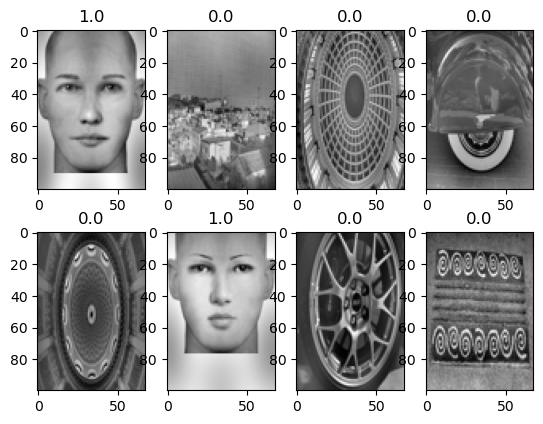

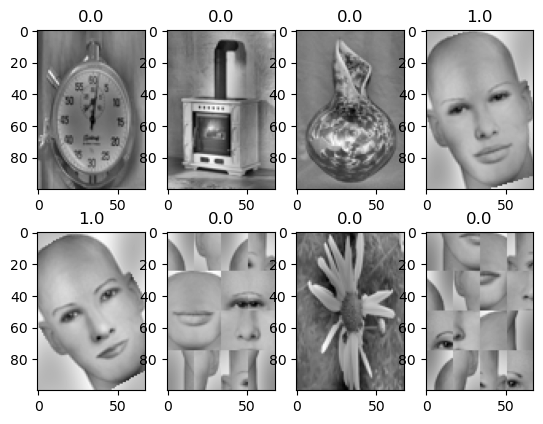

In [33]:
features, labels = next(iter(train_dl))

fig, axs = plt.subplots(2, 4)
i = 0
for ax in axs.flat:
    ax.imshow(features[i].squeeze(0), cmap="gray")
    ax.set_title(labels[i].item())
    i += 1

features, labels = next(iter(train_dl))

fig, axs = plt.subplots(2, 4)
i = 0
for ax in axs.flat:
    ax.imshow(features[i].squeeze(0), cmap="gray")
    ax.set_title(labels[i].item())
    i += 1

print(labels[0].dtype)

In [34]:
class NeuralNetwork(nn.Module):
    def __init__(self, size=(68, 100)):
        super().__init__()
        self.flatten = nn.Flatten()

        self.layers = nn.Sequential(
            nn.Linear(size[0]*size[1], 3400),
            nn.Tanh(),
            nn.Linear(3400, 1700),
            nn.Tanh(),
            nn.Linear(1700, 1),
            nn.Sigmoid()
        )


    def forward(self, X):
        return self.layers(self.flatten(X))

In [35]:
def train_loop(dataloader, model, loss_fn, optimizer, epochs):
    losses = []
    batches = len(dataloader)

    model.train()
    for e in range(epochs):
        curr_loss = 0
        for batch, (X, y) in enumerate(tqdm.tqdm(dataloader)):
            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred.squeeze(-1), y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            curr_loss += loss.item()
        
        losses.append(curr_loss/batches)
        
    return losses

        

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred.squeeze(-1), y).item()
            print(f"Predicted class: {torch.flatten(torch.round(pred))}")
            print(f"Label: {y}")
            correct += (torch.flatten(torch.round(pred)) == y).type(torch.float).sum().item()

    test_loss /= batches
    correct /= size
    return test_loss, correct

In [36]:
model = NeuralNetwork()

In [37]:
lr = 1e-4
epochs = 8
loss_fn = nn.BCELoss(reduction="mean")
#loss_fn = nn.NLLLoss(reduction="mean")
optim = torch.optim.Adam(model.parameters(), lr=lr)

In [38]:
train_losses = train_loop(train_dl, model, loss_fn, optim, epochs)

100%|██████████| 118/118 [00:29<00:00,  4.06it/s]


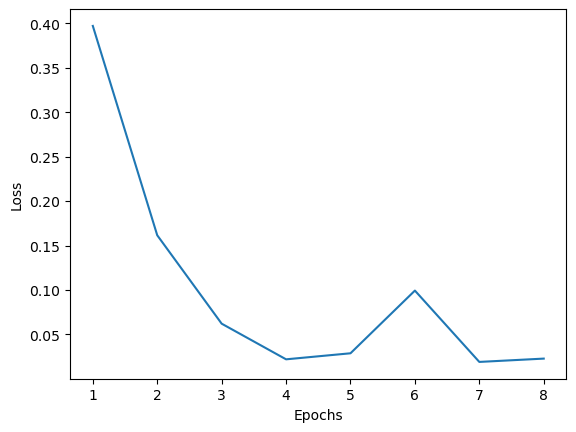

In [39]:
plt.figure()
plt.plot(list(range(1, len(train_losses)+1)), train_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [40]:
#test_loss, test_acc = test_loop(test_dl, model, loss_fn)

In [41]:
train_loss, train_acc = test_loop(train_dl, model, loss_fn)

Predicted class: tensor([1., 1., 1., 0., 0., 0., 1., 1.])
Label: tensor([1., 1., 1., 0., 0., 0., 1., 1.])
Predicted class: tensor([0., 1., 1., 1., 0., 0., 0., 0.])
Label: tensor([0., 1., 1., 1., 0., 0., 0., 0.])
Predicted class: tensor([1., 0., 1., 1., 1., 1., 0., 0.])
Label: tensor([1., 0., 1., 1., 1., 1., 0., 0.])
Predicted class: tensor([0., 0., 0., 0., 1., 1., 0., 1.])
Label: tensor([0., 0., 0., 0., 1., 1., 0., 1.])
Predicted class: tensor([1., 0., 0., 0., 0., 0., 1., 0.])
Label: tensor([1., 0., 0., 0., 0., 0., 1., 0.])
Predicted class: tensor([1., 0., 0., 1., 1., 0., 0., 0.])
Label: tensor([1., 0., 0., 1., 1., 0., 0., 0.])
Predicted class: tensor([0., 1., 1., 1., 1., 0., 1., 1.])
Label: tensor([0., 1., 1., 1., 1., 0., 1., 1.])
Predicted class: tensor([1., 1., 1., 0., 1., 1., 1., 1.])
Label: tensor([1., 1., 1., 0., 1., 1., 1., 1.])
Predicted class: tensor([0., 1., 1., 0., 1., 0., 0., 0.])
Label: tensor([0., 1., 1., 0., 1., 0., 0., 0.])
Predicted class: tensor([0., 1., 0., 1., 1., 1

In [42]:
print(f"{epochs} epochs")
print(f"{type(optim)} optimizer")
print(f"Learning rate is {lr}")
print(f"Train accuracy is {train_acc}")
print(f"Train loss in {train_loss}")
#print(f"Test accuracy is {test_acc}")
#print(f"Test loss in {test_loss}")

8 epochs
<class 'torch.optim.adam.Adam'> optimizer
Learning rate is 0.0001
Train accuracy is 0.9957627118644068
Train loss in 0.03806449559500433


In [43]:
shuffle_dl = get_dataloader_shuffled(num_rotations=0, num_translations=0)

In [44]:
shuffle_loss, shuffle_acc = test_loop(shuffle_dl, model, loss_fn)

Predicted class: tensor([0., 1., 0., 1., 1., 1., 1., 0.])
Label: tensor([0., 1., 0., 1., 1., 1., 1., 0.])
Predicted class: tensor([0., 1., 0., 0., 1., 0., 1., 0.])
Label: tensor([0., 1., 0., 0., 1., 0., 1., 0.])
Predicted class: tensor([1., 0., 1., 0., 1., 0., 1., 1.])
Label: tensor([1., 0., 1., 0., 1., 0., 1., 1.])
Predicted class: tensor([0., 1., 1., 1., 1., 0., 1., 1.])
Label: tensor([0., 1., 1., 1., 1., 0., 0., 1.])
Predicted class: tensor([0., 0., 1., 1., 0., 0., 1., 0.])
Label: tensor([0., 0., 1., 1., 0., 0., 1., 0.])
Predicted class: tensor([0., 0., 0., 1., 0., 1., 0., 0.])
Label: tensor([0., 0., 0., 1., 0., 1., 0., 0.])
Predicted class: tensor([1., 0., 1., 1., 1., 0., 0., 1.])
Label: tensor([1., 0., 1., 0., 1., 0., 0., 1.])
Predicted class: tensor([0., 1., 1., 0., 0., 0., 1., 0.])
Label: tensor([0., 1., 1., 0., 0., 0., 1., 0.])
Predicted class: tensor([0., 0., 0., 1., 0., 0., 1., 1.])
Label: tensor([0., 0., 0., 1., 0., 0., 1., 1.])
Predicted class: tensor([1., 1., 1., 1., 0., 1

In [45]:
print(f"Shuffled loss is {shuffle_loss}")
print(f"Shuffle accuracy is {shuffle_acc}")

Shuffled loss is 0.043877287112991326
Shuffle accuracy is 0.984375


In [46]:
block_shuffle_dl = get_dataloader_block_shuffled(num_rotations=0, num_translations=0)

In [47]:
block_shuffle_loss, block_shuffle_acc = test_loop(block_shuffle_dl, model, loss_fn)

Predicted class: tensor([0., 1., 1., 0., 0., 1., 0., 1.])
Label: tensor([0., 1., 1., 0., 0., 1., 0., 1.])
Predicted class: tensor([1., 1., 1., 1., 1., 1., 0., 0.])
Label: tensor([1., 1., 0., 1., 1., 1., 0., 0.])
Predicted class: tensor([0., 0., 1., 1., 0., 0., 1., 0.])
Label: tensor([0., 0., 1., 1., 0., 0., 1., 0.])
Predicted class: tensor([1., 0., 0., 1., 1., 0., 1., 1.])
Label: tensor([1., 0., 0., 1., 1., 0., 1., 1.])
Predicted class: tensor([0., 0., 1., 1., 0., 0., 1., 1.])
Label: tensor([0., 0., 1., 1., 0., 0., 0., 1.])
Predicted class: tensor([1., 1., 0., 0., 0., 0., 1., 1.])
Label: tensor([1., 1., 0., 0., 0., 0., 1., 1.])
Predicted class: tensor([1., 1., 1., 0., 0., 0., 0., 1.])
Label: tensor([1., 1., 1., 0., 0., 0., 0., 1.])
Predicted class: tensor([1., 0., 1., 0., 0., 1., 0., 1.])
Label: tensor([1., 0., 1., 0., 0., 1., 0., 1.])
Predicted class: tensor([1., 1., 0., 1., 1., 1., 0., 0.])
Label: tensor([1., 1., 0., 1., 0., 1., 0., 0.])
Predicted class: tensor([1., 1., 1., 0., 0., 1

In [48]:
print(f"Block shuffled loss is {block_shuffle_loss}")
print(f"Block shuffle accuracy is {block_shuffle_acc}")

Block shuffled loss is 0.12554339314147
Block shuffle accuracy is 0.9609375


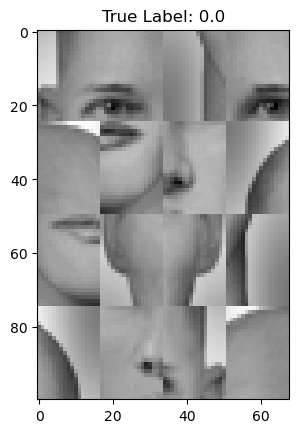

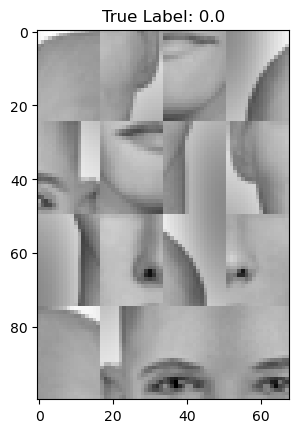

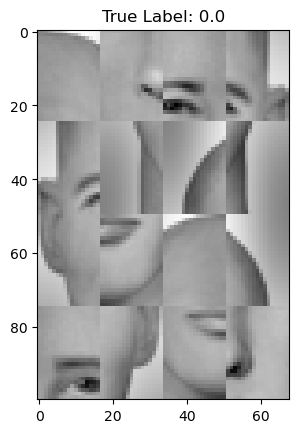

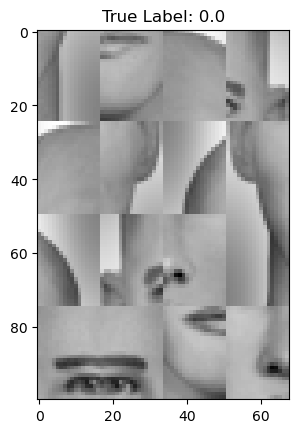

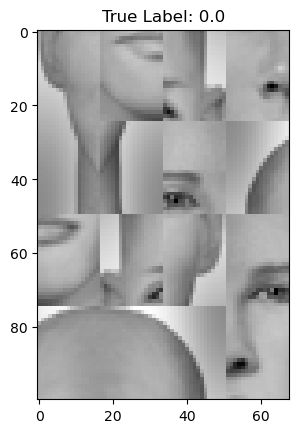

In [49]:
for features, labels in block_shuffle_dl:
    for i in range(len(labels)):
        pred = model(features[i])
        pred_class = torch.flatten(torch.round(pred))
        if pred_class.item() != labels[i].item():
            plt.figure()
            plt.imshow(features[i].squeeze(), cmap="gray")
            plt.title(f"True Label: {labels[i].item()}")
            plt.show()

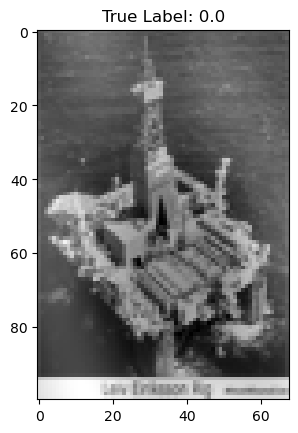

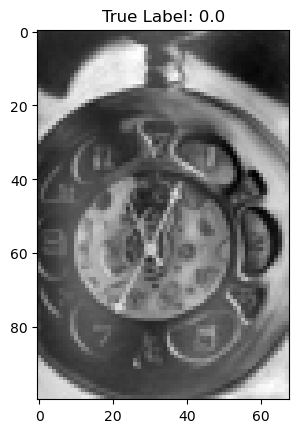

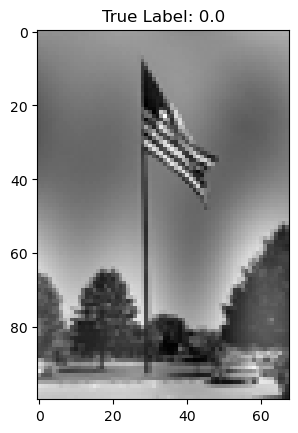

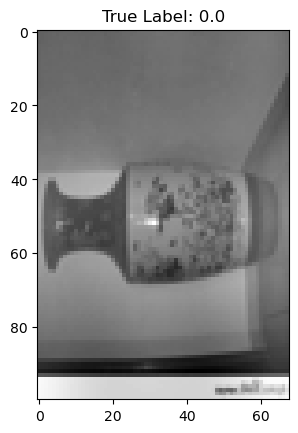

In [53]:
for features, labels in train_dl:
    for i in range(len(labels)):
        pred = model(features[i])
        pred_class = torch.flatten(torch.round(pred))
        if pred_class.item() != labels[i].item():
            plt.figure()
            plt.imshow(features[i].squeeze(), cmap="gray")
            plt.title(f"True Label: {labels[i].item()}")
            plt.show()

In [50]:
sample_size = len(block_shuffle_dl.dataset)
num_block_shuffled_faces = sample_size//2
num_misclassified = sample_size*(1-block_shuffle_acc)

print(f"False positive rate: {num_misclassified/num_block_shuffled_faces}")

False positive rate: 0.078125


In [51]:
print(f"{sample_size} block-shuffled faces")

128 block-shuffled faces


In [52]:
X = load_eye_inhibition()
X_aug = augment_data(X, num_rotations=3, num_translations=3)
print(X_aug.shape[0])

448
